# VIXM Predictor Feature Importance using an adaBoost Model

### Introduction

This notebook presents a machine learning model designed to predict the direction of returns for the VIXM ETN on the following trading day.

By constructing the algorithm, we can see which features would be more important to predict the movements of the VIXM.

We extract or calculate a range of features from a predefined list of tickers using Yahoo Finance data. These features include:

- Close prices
- Returns
- Volume
- GARCH models for volatility estimation
- Squared returns
- SPY historical volatility
- Day-of-the-week and month-of-the-year seasonality effects
- Principal components analysis (PCA) lagged by 1 to 5 days, representing historical movements

The feature extraction and model training are organized into two separate modules:
> `vixcoin_functions/feature_functions.py`  
> `vixcoin_functions/pca_and_training.py`

The core of this strategy is powered by the **AdaBoost algorithm**, which generates daily signals (`0` or `1`). These signals dictate the trading strategy:  
- **Buy** VIXM when the signal is `1`  
- **Sell** VIXM when the signal returns to `0`

In addition to signal generation, the code provides the following analyses:
- Profitability assessment of the trading strategy
- Model accuracy evaluation
- Feature importance analysis


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
from pathlib import Path
import datetime as dt
from datetime import datetime, timedelta
from pandas.tseries.offsets import DateOffset

import pandas as pd
import numpy as np
import yfinance as yf
from sklearn.metrics import classification_report, accuracy_score, f1_score, recall_score
from sklearn.ensemble import AdaBoostClassifier
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.preprocessing import MinMaxScaler
import hvplot.pandas
import matplotlib.pyplot as plt
import seaborn as sns

# Add vixcoin_functions to sys.path if not already included
module_path = str(Path("vixcoin_functions/"))
if module_path not in sys.path:
    sys.path.append(module_path)

# Import functions from feature_functions and pca_and_training modules
from data_load_and_cleanup import (
    upload_configuration,
    process_data_pipeline
)
from feature_functions import (
    garch_fit_and_predict, 
    correlation_filter,
    get_prices_component,
    get_return_component,
    get_volume_component,
    get_garch_component,
    get_return_squared,
    get_ticker_volatilities,
    get_day_of_week_component,
    get_month_component,
    get_X,
    setup_signal,
    shift_signal_for_prediction
)
from pca_and_training import (
    split_training_test_data,
    scale,
    add_pca,
    random_over_sample
)
from visualizations import(
    plot_tickers_with_scaling,
    plot_profitability_ts,
    plot_cum_profit
)

# Upload Configuration

In [3]:
config = upload_configuration('config.yml', display_configuration=False)

Configuration uploaded succesfully


In [4]:
# Some re-used variables from config
start_date_volatilities = (pd.to_datetime(config['start_date']) + DateOffset(days=364)).date()
start_date = config['start_date']
end_date = config['end_date']
demo_mode = config['demo_mode']
ticker_list = config['ticker_list']
tuning_mode = config['tuning_mode']

print(f"start date: {start_date}")
print(f"end date  : {end_date}")
print(f"rolling volatilities start date: {start_date_volatilities}")
print(f"Current number of tickers: {len(config['ticker_list'])}")

start date: 2011-01-05
end date  : 2025-01-05
rolling volatilities start date: 2012-01-04
Current number of tickers: 30


# Data Upload and Cleanup

In [5]:
data = process_data_pipeline(config, display_detailed_steps=False)

Raw data of prices and volume has been succesfully loaded
For the following tickers:
    Prices: ['VIXM', '^VIX', 'SPY', 'VIXY', 'GBPUSD=X', 'BRLUSD=X', 'DX-Y.NYB', 'USDJPY=X', '^TNX', 'ZF=F', 'NQ=F', 'NKD=F', 'LQD', 'AAPL', 'AMZN', 'MU', 'MSFT', 'BMY', 'PLD', 'FXI', 'FEZ', '^FTSE', '^FCHI', '^GSPC', 'GLD', 'SLV', 'ES=F', 'QM=F', 'BIO=F', 'AGG']
    Volume: ['VIXM', '^VIX', 'SPY', 'VIXY', 'GBPUSD=X', 'BRLUSD=X', 'DX-Y.NYB', 'USDJPY=X', '^TNX', 'ZF=F', 'NQ=F', 'NKD=F', 'LQD', 'AAPL', 'AMZN', 'MU', 'MSFT', 'BMY', 'PLD', 'FXI', 'FEZ', '^FTSE', '^FCHI', '^GSPC', 'GLD', 'SLV', 'ES=F', 'QM=F', 'BIO=F', 'AGG']

prices data succesfully cleaned
volume data succesfully cleaned
Saved clean_prices.csv to data
Saved clean_volume.csv to data
Saved clean_d_returns.csv to data


# Plot of Prices
Try other characteristics using key = 'volume' or key = 'd_returns'

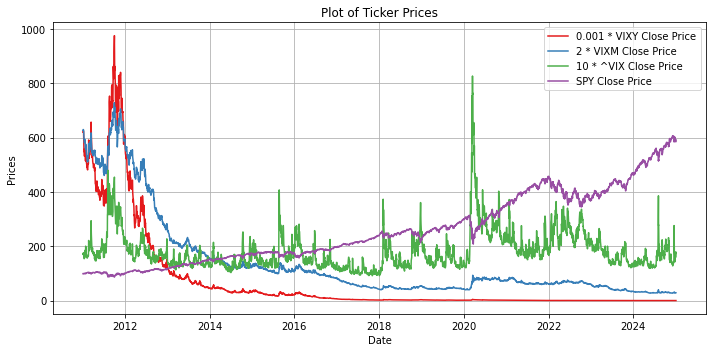

True

In [6]:
plot_tickers_with_scaling(
            data,
            key='prices',
            as_is_tickers=['SPY'],
            scaled_tickers=['VIXY','VIXM','^VIX'],
            scaled_factors=[0.001,2,10]
        )

# Generation of the Features Matrix X

Here we generate the components that will be part of the feature matrix

In [7]:
X_components = {}

### X1: close prices
    * Close prices of international indexes of stocks and bonds, 
    * key stocks, 
    * currency exchange rates, 
    * commodities 

In [8]:
# get first component X1
X_components[1], vixm, vixm_ret = get_prices_component(
    data['prices'], config, display_results=False)

Calculation of price component completed


### X2: security returns

In [9]:
X_components[2] = get_return_component(
        daily_returns_df=data['d_returns'],
        config=config,
        display_results=False
)

Calculation of returns component completed


### X3: security volume

In [10]:
X_components[3] = get_volume_component(volume_df=data['volume'], config=config,
        vixm=vixm, display_results=False
)

Succesful calculation of security volume component X3


### X4: GARCH Models1
    * GJR-GARCH Model conditional volatility
    * Model a response to shocks
    * Allow an asymmetryc t-student distribution of errors

In [11]:
X_components[4] = get_garch_component(
    config=config,
    security_returns_df=data['d_returns'],
    display_results=False
    )

GARCH Process fit and predictions completed for component X4


### X5: Return squared


In [12]:
X_components[5] = get_return_squared(
    config,
    vixm_ret,
    security_returns_df=data['d_returns'],
    display_results=False
    )

Return squared calculation completed for componenent 5 (X5)


### X6: volatility of the SPY in several rolling windows

In [13]:
X_components[6] = get_ticker_volatilities(
    start_date_volatilities=start_date_volatilities,
    vixm=vixm,
    returns=data['d_returns'],
    ticker='SPY',
    config=config,
    display_results=False
)

Rolling volatilities component completed (X6)


### X10: Day of the Week effect

In [14]:
X_components[10] = get_day_of_week_component(
    close_prices_df=data['prices'],
    display_results=False
)

Calculation of day of the week effect component (X10) completed.


### X11: Month effect

In [15]:
X_components[11] = get_month_component(
    close_prices_df=data['prices'],
    display_results=False
)

Calculation of day of the week effect component (X10) completed.


In [16]:
X_components.keys()

dict_keys([1, 2, 3, 4, 5, 6, 10, 11])

# Construction of feature matrix X

In [17]:
X = get_X(X_components,config,inclusion_list=['all'])
X.shape

Component 1: prices included
Component 2: return included
Component 3: volume included
Component 4: garch included
Component 5: return_squared included
Component 6: spy_volatilities_lags included
Component 10: day-of_week_effect included
Component 11: month_effect included


(3392, 156)

# y:  Set the Signal

In [18]:
# Re-upload for convenience
config = upload_configuration('config.yml', display_configuration=False)

Configuration uploaded succesfully


In [19]:
y, XY = setup_signal(X, config, display_results=True)

Signal value_counts:
Signal
0.0       2026
1.0       1366
dtype: int64

XY.shape:  (3392, 157)

VIXM return and signal slide:
             VIXM_ret  Signal
Date                        
2012-01-04 -0.019329     0.0
2012-01-05 -0.005631     0.0
2012-01-06 -0.011468     0.0
2012-01-09 -0.006015     0.0
2012-01-10 -0.007493     0.0
...              ...     ...
2024-12-27  0.021986     1.0
2024-12-30  0.011103     1.0
2024-12-31 -0.007550     0.0
2025-01-02  0.010373     1.0
2025-01-03 -0.017112     0.0

[3392 rows x 2 columns]


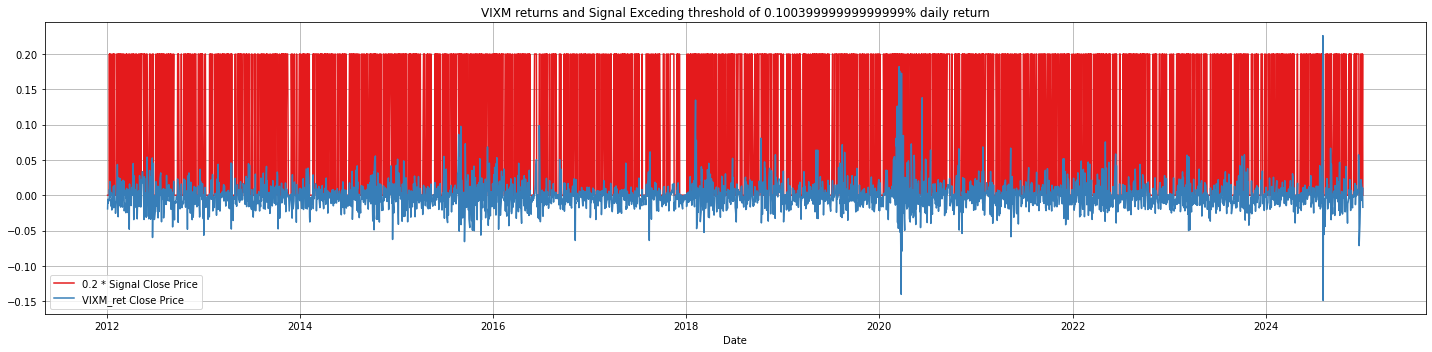

True

In [20]:
# Plotting return signals exceding the threshold
config_key_col = f"{config['key_column']}_ret"
plot_tickers_with_scaling(
            XY,
            key=None,
            as_is_tickers=[config_key_col],
            scaled_tickers=['Signal'],
            scaled_factors=[0.2],
            height=5,
            wide=20,
            title=f"{config['key_column']} returns and Signal Exceding threshold of {100 * config['threshold']}% daily return"
        )

**Obs:** the times of higher volatility display a higher density of signals, as expected. Let´s remember that higher returns in absolute value comes in clusters of high volatility.

In [21]:
# Mark as 99 the missing value after shift to recognize later when adding PCA features
X, y = shift_signal_for_prediction(XY, config, signal_colname="Signal", display_results=True)

Signal prior to shift
            VIXM_ret  Signal
Date                        
2012-01-04 -0.019329     0.0
2012-01-05 -0.005631     0.0
2012-01-06 -0.011468     0.0
2012-01-09 -0.006015     0.0
2012-01-10 -0.007493     1.0
...              ...     ...
2024-12-27  0.021986     1.0
2024-12-30  0.011103     0.0
2024-12-31 -0.007550     1.0
2025-01-02  0.010373     0.0
2025-01-03 -0.017112     NaN

[3392 rows x 2 columns]
XY After shift:
             VIXM_close  ^VIX_close   SPY_close     VIXY_close  GBPUSD=X_close  \
Date                                                                            
2012-01-04  284.119995   22.219999  100.910881  562640.000000        1.564407   
2012-01-05  282.519989   21.480000  101.179565  550080.000000        1.560939   
2012-01-06  279.279999   20.629999  100.918808  541760.000000        1.550171   
2012-01-09  277.600006   21.070000  101.163780  533440.000000        1.541949   
2012-01-10  275.519989   20.690001  102.040886  522720.000000        1.54

In [22]:
# Review of correlations - interactive plot when used with jupyter notebooks or voila
correlations = X.corr()

correlations.hvplot.heatmap(
    cmap='coolwarm', 
    title='Feature Correlation Heatmap', 
    width=1500, 
    height=1500,
    rot=90,
    colorbar=True
)

:HeatMap   [columns,index]   (value)

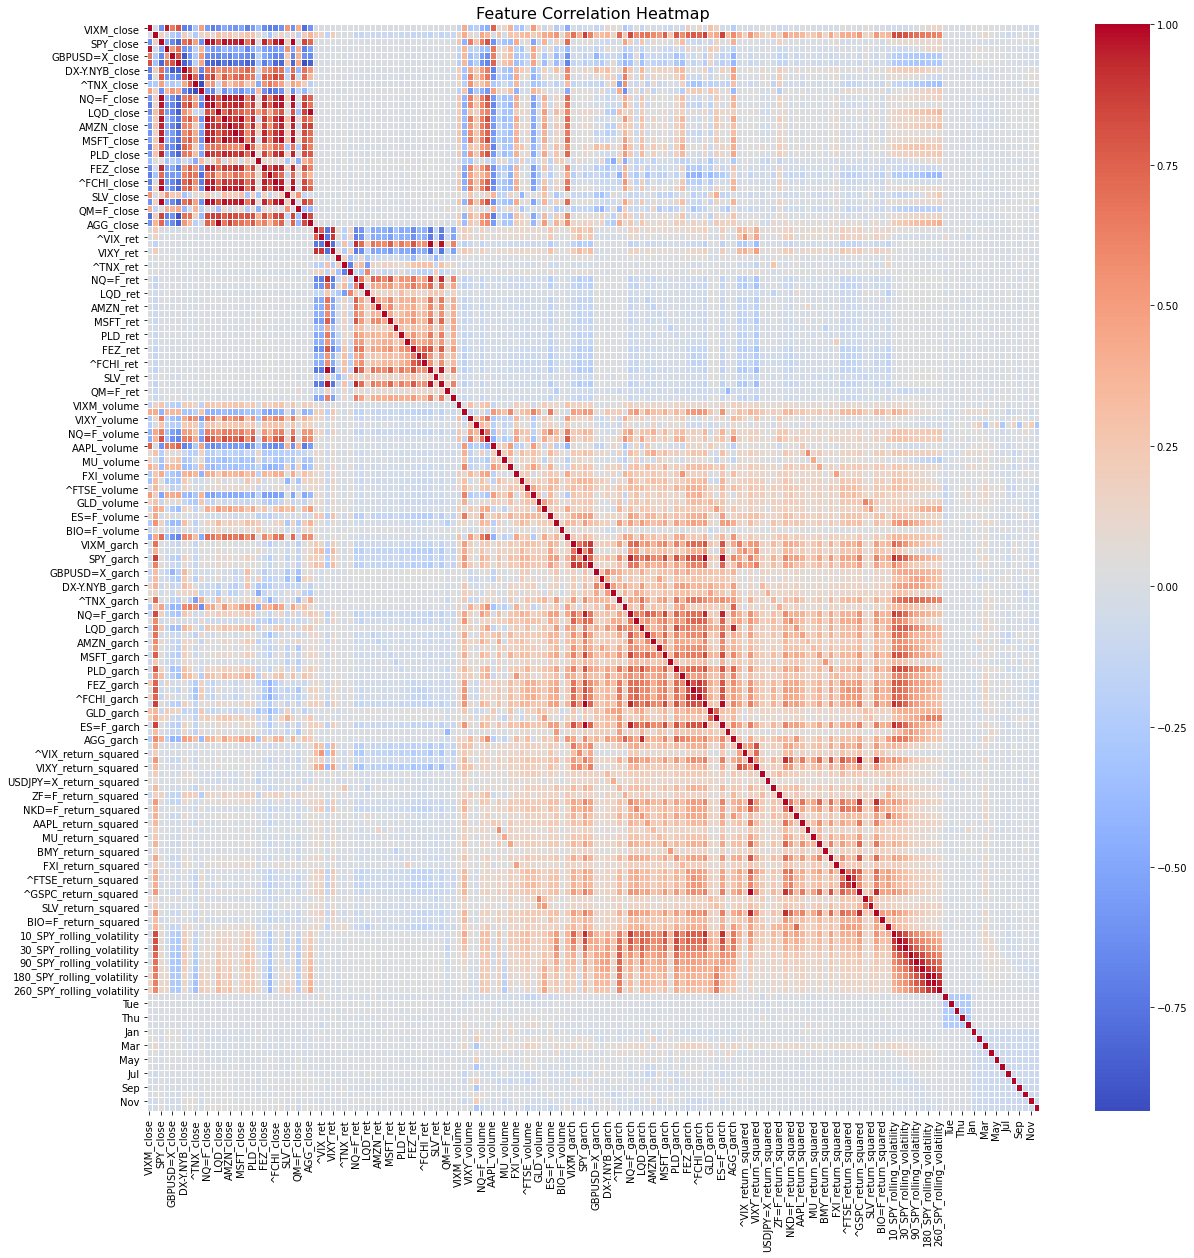

In [23]:
# Compute correlation matrix - Static plot - Made too be able to see in GitHub
correlations = X.corr()

# Plot heatmap
plt.figure(figsize=(20, 20))
sns.heatmap(
    correlations,
    cmap='coolwarm',
    annot=False,         # Show correlation values
    fmt=".2f",          
    linewidths=0.5,     
    cbar=True
)
plt.title('Feature Correlation Heatmap', fontsize=16)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()


# Addition of principal components
Number of components to add are given in the config. As of now, 6 components with lags of 5 days.
That means, that data up to the previous week is included, but instead of adding all the features, we select just
the 6 first principal components which represent more than 50% of the variance in the data.

Training period: 2012-01-04 00:00:00 to 2023-05-04 00:00:00
X_train shape: (2957, 156), y_train shape: (2957,)
X_test shape: (435, 156), y_test shape: (435,)
y_train value counts:
0.0    1758
1.0    1199
Name: Signal, dtype: int64
Time series data split completed 

X_train_scaled shape: (2957, 156)
X_test_scaled shape: (435, 156)
Data scaled succesfully, based on trained data.
Explained variance of first 40 components: 96.47%
Explained variance ratio per component: 


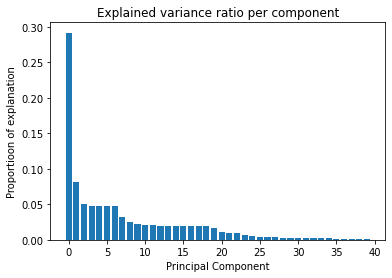

Principal components shape: (3392, 40)

1-5 day-lag components included
Each lagged component considering 40 principal components

        The lagged principal components have been succesfully added to the features matrix X, 
        the y component was trunc to match X's index,
        and the prediction vector was extracted for tomorrow signal.
    


In [24]:
X_pc, y_pc, prediction_vector = add_pca(X=X, y=y,
    n_components=config["num_pca_components"], 
    t=config["num_lags_to_include"], 
    training_period_months=config['training_period_months'],
    scaler_type='MinMaxScaler',
    display_results=True,
    include_df_output=False
)

# Split the Extended Data
pca were calculated on training data only
Balance with random over sample was tried, but it didn't improve the performance.

In [25]:
# Split of data in train and test, applying temporal window function that respect time series order
X_train, y_train, X_test, y_test = split_training_test_data(
    X_pc, y_pc, training_period_months=config["training_period_months"]
)
y_pc.value_counts()

Time series data split completed 



0.0    2021
1.0    1365
Name: Signal, dtype: int64

# Model Estimation

In [26]:
# Initiate the model
model = AdaBoostClassifier(  
    n_estimators=config['adaboost_estimators'],
    learning_rate=config['learning_rate_adaboost'],
    random_state=config['seed']
)
model

AdaBoostClassifier(learning_rate=1, n_estimators=10, random_state=19)

In [27]:
# Fit the model 
model = model.fit(X_train, y_train)

# Predict with the model
pred = model.predict(X_test)
pred_tomorrow = model.predict(prediction_vector)
pred_tomorrow

array([1.])

In [28]:
# Use a classification report to evaluate the model using the predictions and testing data
report = classification_report(y_test, pred, zero_division=0)

# Print the classification report
print("         Predictive Moodel Classification Report")
print(report)


         Predictive Moodel Classification Report
              precision    recall  f1-score   support

         0.0       0.62      0.69      0.65       263
         1.0       0.41      0.34      0.37       166

    accuracy                           0.55       429
   macro avg       0.52      0.52      0.51       429
weighted avg       0.54      0.55      0.55       429



# Analysis of feature importance in the Model

In [29]:
# Analysis of importance of the difference variables
# get importance
importance_coeficients = model.feature_importances_

feature_importance_df = pd.Series(
    importance_coeficients, 
    index=X_pc.columns
)

# Output of all levels
for i,v in enumerate(importance_coeficients):
    if v !=0:
        print(f"Feature: {i}, {X_pc.columns[i]}, Score: {v}" )
        
# Display of only features that impacted the model
n_important_features = feature_importance_df.loc[feature_importance_df > 0].shape[0]
feature_importance_df.loc[feature_importance_df > 0.006].hvplot(
    kind='barh', 
    height=500,
    title= f"{n_important_features} Features relevant for the VIXM Prediction Model"
)

Feature: 38, LQD_ret, Score: 0.1
Feature: 39, AAPL_ret, Score: 0.1
Feature: 40, AMZN_ret, Score: 0.1
Feature: 66, ^FTSE_volume, Score: 0.1
Feature: 76, SPY_garch, Score: 0.1
Feature: 84, NQ=F_garch, Score: 0.1
Feature: 138, 260_SPY_rolling_volatility, Score: 0.1
Feature: 156, pca1_lag1, Score: 0.1
Feature: 165, pca5_lag2, Score: 0.1
Feature: 179, pca4_lag5, Score: 0.1


:Bars   [index]   (0)

# Profitability Analysis


In [30]:
# VIX size of returns (in absolute value and %)
vixm_return_statistics = abs(100 * data['d_returns']['VIXM']).describe()
display(vixm_return_statistics)

count    3651.000000
mean        1.380516
std         1.501987
min         0.000000
25%         0.428824
50%         1.004020
75%         1.868647
max        22.598523
Name: VIXM, dtype: float64

### In-sample analysis: Return on $1 invested on training data window

In [31]:
results_train_df, cummulative_return_train_df = plot_profitability_ts(
    model=model, X_=X_train, y_=y_train,
    vixm_ret=vixm_ret, data=data, config=config,
    is_train_window=True
)

:NdOverlay   [Variable]
   :Curve   [Date]   (value)

Obs: we see an excelent profitability of the strategy in the train window.

### Out-of-sample analysis: Return on $1 invested on testing data window

In [33]:
results_test_df, cummulative_return_test_df = plot_profitability_ts(
    model=model, X_=X_test, y_=y_test,
    vixm_ret=vixm_ret, data=data, config=config,
    is_train_window=False
)

:NdOverlay   [Variable]
   :Curve   [Date]   (value)

Obs: the predictions out-of-sample are able to reduce significantly the decay effect. Indeed, up to Aug 5 2024 the strategy has 0 decay. Up to the end of 2024, the decay is reduced from a lost of 45% of value of the VIXM ETN to only 84% of the VIXCOIN token.
What is not so encoraging is that the strategy lost the market lost of August 2025.

In [34]:
# Cummulative returns
display(cummulative_return_test_df.iloc[[0, 2]].hvplot.bar(title="Cummulative Returns on Testing Data"))
display(cummulative_return_test_df.iloc[[0, 2]])


:Bars   [index]   (2025-01-02 00:00:00)

VIXM ETN                    0.553619
VIXCOIN Token(in sample)    0.844017
Name: 2025-01-02 00:00:00, dtype: float64

### Comments
0. The VIXM invest in VIX Futures in order to make profit.
1. The VIXM has massive positive returns in moments of crushes in the market, and tends to decay in time due to the rolling effect on its futures contracts. 
2. Due to the decay effect, VIXM can only be profitable for short term trades. Should not be used in a buy and hold strategy.
3. Our algorithmic trading investment strategy on VIXM takes advantage of the good return in market crushes, and in addition allows to generate profit during bull markets.
4. The VIXCoin investment works like a buy and hold strategy, and offers an investment opportunity to diversify a portfolio to reduce risk.


# Conclusions

The VIXM algorithmic strategy demonstrates potential for mitigating the decay of the VIXM instrument by leveraging machine learning techniques. However, there are several areas for improvement to enhance its effectiveness:

1. **Feature Selection and Hyperparameter Tuning**:
   The strategy could benefit from a more rigorous application of feature selection and hyperparameter optimization to improve its predictive performance and robustness.

2. **Performance on Training and Adjacent Data**:
   The strategy performs exceptionally well on the training data and shows promising results on data close to the training window. This indicates its ability to capture short-term patterns effectively.

3. **Limitations with Out-of-Sample Data**:
   As the time horizon extends further from the training window, the strategy's performance begins to degrade. This suggests the need for improvements to generalize the model to new, unseen data.

In conclusion, while the strategy is a strong starting point, addressing these limitations through advanced techniques could make it a more reliable and effective tool for managing the VIXM instrument. 